# DATA 71200: Project 2
### Spring2020 - Lu Tong


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import re
import spacy
nlp = spacy.load("en_core_web_sm")

## Step 1: Load your data, including testing/training split from Project 1.

Data Source: the cleaned version from Project 1

In [2]:
df_train = pd.read_csv('train_clean.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test_clean.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 15)
Test Set Shape = (3263, 14)


In [3]:
df_train.head(3)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,rawtext
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,13,13,6,0,4.384615,69,1,1,0,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,7,7,0,0,4.571429,38,1,0,0,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,22,20,11,0,5.090909,133,3,0,0,All residents asked to 'shelter in place' are ...


In [4]:
df_train_target = df_train['target']
df_train = df_train.drop(columns=['rawtext','target'])
df_test = df_test.drop(columns=['rawtext'])

## Step 2:  Prepare your data
I've created some features in project 1 but I feel word vectorization is most appropriate for higher predicting power.

In [5]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 13)

I use GloVe for Vectorization. I refered to the notebook on Kaggle to conduct my procedure.

Here is the link to GloVe introduction. https://nlp.stanford.edu/projects/glove/

I use pre-trained word vectors to process text. To be specific, I use Wikipedia 2014 + Gigaword 5 datasets. It is available in 3 varieties :50D ,100D and 200 Dimentional.I try 100 D here.

In [6]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bravo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [7]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [8]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7936.52it/s]


In [9]:
embedding_dict={}
with open('glove.6B.100d.txt','rb') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [10]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

embedding for sequential model.
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

In [11]:
train = tweet_pad[:df_train.shape[0]]
test = tweet_pad[df_train.shape[0]:]

## Step 3: Select your target attribute. 
My target attribute is "target", which is a dummy variable indicates whether the tweet content is about real disaster.

My target variable is an binary variable. 

## Step 4: Selected two of the following supervised learning algorithms
I choose Method 1: k-Nearest Neigbors and Method 2: Random Forest

## Step 5: For each of your selected models
•	Run with the default parameters using cross-validation

o	Calculate precision, recall, and F1 for classification

o	Calculate r2, RMSE, and MAE for regression

•	(Where possible) adjust 2-3 parameters for each model

o	Report evaluation metrics for the best and worst performing parameter settings

In [12]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [13]:
X_train,X_test,y_train,y_test=train_test_split(train,df_train_target,test_size=0.15)
print("Shape of Training Datase", X_train.shape)
print("Shape of Validation Dataset", X_test.shape)

Shape of Training Datase (6471, 50)
Shape of Validation Dataset (1142, 50)


### Model 1: KNN 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
#10-fold cross validation with default parameters, default = 5
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_scores = cross_val_score(knn, X_train, y_train, cv=10)

print("cv_scores:\n{}".format(knn_scores))
print("cv_scores mean:\n{}".format(np.mean(knn_scores)))
print(classification_report(y_test, knn.predict(X_test),
                            target_names=["1", "0"]))

cv_scores:
[0.55555556 0.58333333 0.57496136 0.5950541  0.58887172 0.61823802
 0.55023184 0.59196291 0.59196291 0.58204334]
cv_scores mean:
0.5832215076437038
              precision    recall  f1-score   support

           1       0.64      0.66      0.65       670
           0       0.50      0.47      0.48       472

   micro avg       0.58      0.58      0.58      1142
   macro avg       0.57      0.57      0.57      1142
weighted avg       0.58      0.58      0.58      1142



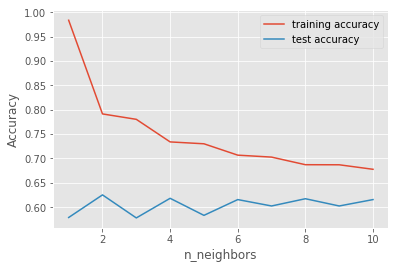

In [16]:
#Tuning Parameters
#Setting: euclidean_distance (l2)
# try n_neighbors from 5 to 20
training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [17]:
knn = KNeighborsClassifier()

#dictionary of all values of k
param_grid = {"n_neighbors": [5,10,15,20],
             "weights" : ['uniform','distance'],
             "metric" : ['euclidean','manhattan']
             }

#grid search on all values of k in dictionary
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

In [18]:
# Fit the grid search to the data
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

In [19]:
#10-fold cross validation with best parameters
knnbest = KNeighborsClassifier(n_neighbors = 15,weights = "distance", metric = "manhattan")
knnbest.fit(X_train, y_train)
knn_scores = cross_val_score(knn, X_train, y_train, cv=10)

print("cv_scores:\n{}".format(knn_scores))
print("cv_scores mean:\n{}".format(np.mean(knn_scores)))
print("Accuracy on test set: {:.3f}".format(knnbest.score(X_test, y_test)))
print(classification_report(y_test, knnbest.predict(X_test),
                            target_names=["1", "0"]))

cv_scores:
[0.55555556 0.58333333 0.57496136 0.5950541  0.58887172 0.61823802
 0.55023184 0.59196291 0.59196291 0.58204334]
cv_scores mean:
0.5832215076437038
Accuracy on test set: 0.632
              precision    recall  f1-score   support

           1       0.66      0.77      0.71       670
           0       0.57      0.44      0.50       472

   micro avg       0.63      0.63      0.63      1142
   macro avg       0.62      0.60      0.60      1142
weighted avg       0.62      0.63      0.62      1142



In [23]:
#get prediction for Kaggle submision
knn_result = knnbest.predict(test)
type(knn_result)

numpy.ndarray

In [26]:
df = pd.DataFrame(data=knn_result , columns=["target"])
df.to_csv('knn.csv',index = False)

After adding the id to the csv, I submitted the result to kaggle and got the feedback.
#### Score for KNN model is : 0.61247

### Model 2: Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

In [28]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_scores = cross_val_score(knn, X_train, y_train, cv=10)

print("cv_scores:\n{}".format(forest_scores))
print("cv_scores mean:\n{}".format(np.mean(forest_scores)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print(classification_report(y_test, forest.predict(X_test),
                            target_names=["1", "0"]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


cv_scores:
[0.55555556 0.58333333 0.57496136 0.5950541  0.58887172 0.61823802
 0.55023184 0.59196291 0.59196291 0.58204334]
cv_scores mean:
0.5832215076437038
Accuracy on test set: 0.632
              precision    recall  f1-score   support

           1       0.66      0.78      0.71       670
           0       0.57      0.43      0.49       472

   micro avg       0.63      0.63      0.63      1142
   macro avg       0.62      0.60      0.60      1142
weighted avg       0.62      0.63      0.62      1142



In [29]:
#Tuning Parameters
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators' : [100, 300, 500],
    'max_depth' : [5, 10, 25],
    'min_samples_leaf': [5, 20, 50],
    'min_samples_split': [2, 5, 10],
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.9min finished


{'max_depth': 25,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [31]:
forestbest = RandomForestClassifier(max_depth = 25,min_samples_leaf = 5,min_samples_split = 5, n_estimators = 500)
forestbest.fit(X_train, y_train)
forest_scores = cross_val_score(forestbest, X_train, y_train, cv=10)

print("cv_scores:\n{}".format(forest_scores))
print("cv_scores mean:\n{}".format(np.mean(forest_scores)))
print("Accuracy on test set: {:.3f}".format(forestbest.score(X_test, y_test)))
print(classification_report(y_test, forestbest.predict(X_test),
                            target_names=["1", "0"]))

cv_scores:
[0.67901235 0.66512346 0.65996909 0.67078825 0.64142195 0.65224111
 0.67387944 0.65224111 0.65069552 0.64705882]
cv_scores mean:
0.6592431102041825
Accuracy on test set: 0.683
              precision    recall  f1-score   support

           1       0.68      0.88      0.76       670
           0       0.70      0.41      0.51       472

   micro avg       0.68      0.68      0.68      1142
   macro avg       0.69      0.64      0.64      1142
weighted avg       0.69      0.68      0.66      1142



In [32]:
#get prediction for Kaggle submision
forest_result = forestbest.predict(test)
df = pd.DataFrame(data=forest_result , columns=["target"])
df.to_csv('forest.csv',index = False)

After adding the id to the csv, I submitted the result to kaggle and got the feedback.
#### Score for RandomForest model is : 0.64826